# Fragment Tutorial

> How to assemble fragments with templates

This tutorial shows how to use `chem_templates` fragment assembly to build highly targeted molecular libraries.

We can use a `Template` to define a series of pass/fail criteria for a single molecule, giving us control over chemical space. But what if we want more fine-grained control over the structure? What if we want molecules that conform to the pattern `[R1]-[linker]-[scaffold]`, with a specific `Template` for each of those sections?

This is challenging from a top-down approach because it requires figuring out how to map arbitrary molecules to the `[R1]-[linker]-[scaffold]`, which involves a dizzying amount of SMARTS definitions. A much easier way is to assemble molecules from the bottom up, ensuring that each fragment in the assembly matches the desired chemotype.

We can accomplish this with the following steps:
1. define templates
2. define assembly schema
3. create fragment library
4. assemble molecules

## Defining Templates

First we need to define templates for our assembly schema. We want molecules to conform to `[R1]-[linker]-[scaffold]`. We will define separate templates for `R1`, `linker`, `scaffold` and the full assembled molecule:

R1 template:
* 1 ring
* no rotatable bonds

Linker template:
* no rings
* at most 4 rotatable bonds
* at most 60 g/mol

Scaffold template:
* 2 rings
* at most 250 g/mol

Full molecule template:
* Valid compound
* Single compound
* <= 8 rotatable bonds
* <=5 hydrogen bond donors
* <=10 hydrogen bond acceptors
* <= 500 g/mol
* <= 5 ClogP

In [ ]:
from chem_templates.chem import Molecule
from chem_templates.fragments import shred_smiles
from chem_templates.assembly import AssemblyInputs, FragmentNode, FragmentLeafNode
from chem_templates.filter import RangeFunctionFilter, ValidityFilter, SingleCompoundFilter, Template

from rdkit.Chem import rdMolDescriptors, Descriptors
from rdkit.Chem import Draw

In [ ]:
def rings(molecule):
    return rdMolDescriptors.CalcNumRings(molecule.mol)

def hbd(molecule):
    return rdMolDescriptors.CalcNumHBD(molecule.mol)

def hba(molecule):
    return rdMolDescriptors.CalcNumHBA(molecule.mol)

def molwt(molecule):
    return rdMolDescriptors.CalcExactMolWt(molecule.mol)

def logp(molecule):
    return Descriptors.MolLogP(molecule.mol)

def rotb(molecule):
    return rdMolDescriptors.CalcNumRotatableBonds(molecule.mol)

In [ ]:
r1_template = Template([
    RangeFunctionFilter(rings, 'rings', 1, 1),
    RangeFunctionFilter(rotb, 'rotatable_bonds', 0, 0)
])

linker_template = Template([
    RangeFunctionFilter(rings, 'rings', 0, 0),
    RangeFunctionFilter(rotb, 'rotatable_bonds', None, 4),
    RangeFunctionFilter(molwt, 'mol_wt', None, 60)
])

scaffold_template = Template([
    RangeFunctionFilter(rings, 'rings', 2, 2),
    RangeFunctionFilter(molwt, 'mol_wt', None, 250)
])

full_template = Template([
    ValidityFilter(),
    SingleCompoundFilter(),
    RangeFunctionFilter(rotb, 'rotatable_bonds', None, 8),
    RangeFunctionFilter(hbd, 'hydrogen_bond_donors', None, 5),
    RangeFunctionFilter(hba, 'hydrogen_bond_acceptors', None, 10),
    RangeFunctionFilter(molwt, 'mol_wt', None, 500),
    RangeFunctionFilter(logp, 'clogp', None, 5)
])

## Define Assembly Schema

Now we define how the fragments will fit together. First we define our leaf nodes with the `FragmentLeafNode` class. Each leaf node is given a name, a set of `mapping_idxs`, and a template.

The `mapping_idxs` define how fragments are mapped and assembled. Mappings are implemented as an annotation on dummy atoms, ie `[*:1]C` would be a carbon atom with a single mapping with `1` as the mapping index.

For this schema, we will use the following mappings:
* R1 - `[1]`
* Linker - `[1,2]`
* Scaffold - `[2]`

This tells us that all `R1` fragments should have a single mapping with `1` as the index - ie `[*:1][R1]`.

Linker fragments should have two mappings with `1` and `2` as the index values  - ie `[*:1][linker][*:2]`

Scaffold fragments should have one mapping with `2` as the index - ie `[*:2][scaffold]`

These will be assembled as `[R1]-[*:1]-[linker]-[*:2]-[scaffold] -> [R1]-[linker]-[scaffold]`

In [ ]:
R1 = FragmentLeafNode('R1', [1], template=r1_template)
linker = FragmentLeafNode('L1', [1, 2], template=linker_template)
scaffold = FragmentLeafNode('scaffold', [2], template=scaffold_template)

Now we need to define how to assemble these fragments. We can do this with the `FragmentNode` class:

In [ ]:
full_molecule = FragmentNode('full_molecule', [scaffold, R1, linker], template=full_template)

This will fuse our three leaf nodes into a single molecule. We can validate our assembly by checking the `dummy_mol` object of the full molecule node:

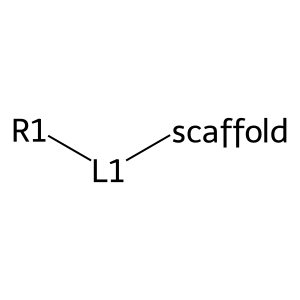

In [ ]:
Draw.MolToImage(full_molecule.dummy)

We used the most simple assembly:

```python
full_molecule = FragmentNode('full_molecule', [scaffold, R1, linker], template=full_template)
```

This grabs our three leaf nodes and assembles them all at once.

If we wanted, we could use more intermediate nodes to give more control. Say we wanted to add another template check on `[R1]-[linker]`, we could do that with another intermediate node:

```python
r1_linker_fused = FragmentNode('r1_linker_fused', [R1, linker], template=r1_fused_template)
full_molecule = FragmentNode('full_molecule', [scaffold, r1_linker_fused], template=full_template)
```

Or we could have an intermediate node for `[linker]-[scaffold]`:

```python
linker_scaffold_fused = FragmentNode('linker_scaffold_fused', [scaffold, linker], template=linker_scaffold_fused_template)
full_molecule = FragmentNode('full_molecule', [linker_scaffold_fused, R1], template=full_template)
```

In practice, you should add an intermediate node whenever you think another template would be useful

## Create Fragment Library

Now we need some fragments. To make things easy, we'll take a set list of SMILES and shred them to create fragments

In [ ]:
smiles = ['CNc1nc(SCC(=O)Nc2cc(Cl)ccc2OC)nc2ccccc12',
       'COc1ccc(C(=O)Oc2ccc(/C=C3\\C(=N)N4OC(C)=CC4=NC3=O)cc2OC)cc1',
       'Cc1sc(NC(=O)c2ccccc2)c(C(N)=O)c1C',
       'COc1ccc(NCc2noc(-c3ccoc3)n2)cc1OC(F)F',
       'O=C(COC(=O)c1cccc(Br)c1)c1ccc2c(c1)OCCCO2',
       'CCOC(=O)c1nc2ccccc2nc1N1CCN(c2ccc(OC)cc2)CC1',
       'CC(=O)c1cc2c(N)c(C(=O)Nc3cccc4nsnc34)sc2nc1C',
       'O=C(NCCc1csc(-c2ccccc2)n1)Nc1ccc2[nH]ccc2c1',
       'CC(=O)c1ccc(NC(=O)Cn2c(=O)n(-c3ccc(F)cc3)c(=O)c3oc4ccccc4c32)cc1',
       'O=C(NCCC[NH+]1Cc2ccccc2C1)c1cccc(Cn2cccn2)c1',
       'O=C1CC(C(=O)Nc2ccc3c(c2)OCCO3)=c2ccccc2=[NH+]1',
       'O=C(CSCc1ccc(F)cc1Cl)Nn1c(=S)[nH]c2sc3c(c2c1=O)CCC3',
       'CN(CCS(C)(=O)=O)CC(=O)c1ccc2c(c1)CCC2',
       'Cc1nn2ccccc2c1C(=O)N1CCN(C(=O)NC(C)C)CC1',
       'CCN(CCO)c1ncnc(Nc2ccc(C)cc2C)c1N',
       'O=C(COc1ccc(Cl)cc1Cl)Nc1ccc(S(=O)(=O)N2CCOCC2)cc1',
       'COc1ccc(-c2ccc(=O)n(CCCC(=O)NC3CCCC3)n2)cc1',
       'CCOc1cc(NC(=O)c2cccnc2Cl)ccc1OC',
       'CCc1nn(C)cc1CNC(=O)CNC(=O)c1cccc([N+](=O)[O-])c1',
       'Cc1ccc(CNC(=O)c2ccccc2NC(=O)c2ccc(NC(=O)C(C)C)cc2)cc1']

In [ ]:
frags = shred_smiles(smiles, [1,2,3], 25, 4, False)
len(frags)

0 20
1 368
2 45
3 8


437

## Assemble Molecules

Now we do the assembly itself. First we run `full_molecule.build_assembly_pools`. This gives us a dictionary of `AssemblyPool` objects holding fragments that match the template for each leaf node.

Then we create our `AssemblyInputs` and pass them to `full_molecule.assemble`. The result is a pool of molecules that all conform to our `[R1]-[linker]-[scaffold]` chemotype and match each template we created above

In [ ]:
frag_molecules = [Molecule(i) for i in frags]

In [ ]:
assembly_dict = full_molecule.build_assembly_pools(frag_molecules)
assembly_dict

{'L1': AssemblyPool: 41 items,
 'R1': AssemblyPool: 11 items,
 'scaffold': AssemblyPool: 33 items}

In [ ]:
assembly_inputs = AssemblyInputs(assembly_dict, 1000, 5000)

In [ ]:
assembled = full_molecule.assemble(assembly_inputs)
assembled

scaffold
R1
L1
full_molecule


AssemblyPool: 5659 items

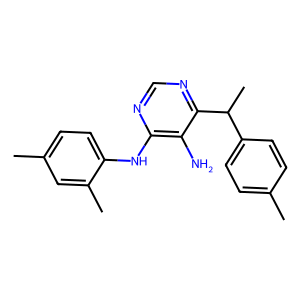

In [ ]:
Draw.MolToImage(assembled[0].mol)